In [223]:
import pandas as pd
import numpy as np

# Different possible regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

# Other process packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
# import statsmodels

# Model scoring and assessment packages
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import shap

# Model optimization packages
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Visualization packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.graph_objects as go

Helper functions

In [224]:
def plot_permutation_importance(clf,
                                X,
                                y,
                                scoring,
                                random_state,
                                ax):
    '''
    
    '''
    result = permutation_importance(clf,
        X,
        y,
        scoring=scoring,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel(scoring)

    fig.tight_layout()
    plt.show()

    return ax

def display_feature_importance(clf,
                               X_train,
                               X_test,
                               y_train,
                               y_test):
    '''
    
    '''

    results = pd.Series(
        clf.feature_importances_,
        index=clf.feature_names_in_,
        ).sort_values(ascending=False)
    print("Feature Importance Ranking:\n", results.index)
    results.plot.bar(figsize=(15, 5))
    r = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{clf.feature_names_in_[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini Importance")
    plot_permutation_importance(clf, X_train, y_train, "neg_mean_absolute_error", 42, ax2)
    ax2.set_xlabel("Decrease in neg_mean_absolute_error")
    # fig.subtitle(
    #     "Impurity-based Feature Importance vs Permutation Importances /n on multicolinear features (train set)")
    _ = fig.tight_layout()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_permutation_importance(clf, X_test, y_test, "neg_mean_absolute_error", 42, ax)
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel("Decrease in neg_mean_absolute_error")
    _ = ax.figure.tight_layout()
    plt.show()

Read in the main dataset and drop unnecessary columns.

In [225]:
df = pd.read_csv('final_merge.csv',
    index_col=0)
print(f'Dataframe shape: {df.shape}')
print(f'dataframe columns: {df.columns}')

# Drop columns with percentages
df = df[df.columns.drop(list(df.filter(regex='Percent')))]


Dataframe shape: (1730, 54)
dataframe columns: Index(['disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Percent!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2

Review the dataframe.

In [226]:
df.head()

,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Name,Date_y,Latitude,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,1147,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,87.175749
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,1384,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,349.863220
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,1766,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,63.975663
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,333,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,111.469171
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,2457,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,72.859249


In [227]:
df.describe()

,disasterNumber,fipsStateCode,fipsCountyCode,year,validReg_own,DamageBetween1and1000,DamageBetween10001and2000,DamageBetween20001and3000,DamageGreaterThan3000,validReg_rent,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Date_y,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
count,1730.000000,1730.000000,1730.000000,1730.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1689.000000,...,1730.000000,1730.000000,1730.000000,1730.000000,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000
mean,3094.516763,31.530636,108.391908,2012.023699,6090.835960,1841.802685,155.615295,53.805604,66.267951,4555.212552,...,7281.291908,4995.699422,2400.882081,2139.339306,2.012114e+07,97.234104,953.211561,28.673815,-82.800289,236.829505
std,1458.354903,20.591525,119.229293,7.755594,17289.765569,5212.056569,784.883876,372.534664,511.160118,19365.789881,...,16648.966254,12298.887890,6137.119990,5229.259202,7.756742e+04,19.661540,17.364006,4.368017,7.763506,250.074421
min,1479.000000,1.000000,1.000000,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,39.000000,41.000000,-71.000000,-61.000000,2.003072e+07,65.000000,919.000000,18.000000,-97.200000,4.543943
25%,1554.000000,12.000000,43.000000,2004.000000,324.000000,138.000000,2.000000,0.000000,0.000000,106.000000,...,1129.750000,709.250000,357.250000,371.000000,2.004092e+07,80.000000,939.000000,27.200000,-87.900000,81.909737
50%,4019.000000,28.000000,83.000000,2011.000000,1359.000000,464.000000,15.000000,2.000000,2.000000,581.000000,...,2273.000000,1424.500000,768.000000,790.500000,2.011083e+07,95.000000,952.000000,29.300000,-82.200000,152.902961
75%,4400.000000,48.000000,123.000000,2018.000000,4862.000000,1434.000000,73.000000,13.000000,13.000000,2471.000000,...,5992.000000,3657.750000,1880.500000,1896.250000,2.018101e+07,110.000000,965.000000,30.200000,-79.500000,270.123505
max,4834.000000,72.000000,840.000000,2024.000000,331674.000000,99520.000000,23576.000000,11003.000000,11077.000000,374677.000000,...,240198.000000,145008.000000,99878.000000,63843.000000,2.024101e+07,140.000000,986.000000,34.900000,-65.900000,1312.120049


In [228]:
df['fipsCode'].describe()

count     1730.000000
mean     31639.027746
std      20614.641817
min       1001.000000
25%      12117.500000
50%      28038.000000
75%      48071.000000
max      72153.000000
Name: fipsCode, dtype: float64

Merge this dataset with storm information about the closest pass for each observation.

In [229]:
# Rename one column to make merging easier.
df['declarationTitle'].rename('Name')

# Remove HURRICANE from all hurricane names for merging purposes.
df['Name'] = df['Name'].str.replace('HURRICANE ', '')
df.columns

Index(['disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'E

In [230]:
# Load the data to be merged and rename columns to be more specific.
df_closest_pass = pd.read_csv('closest_pass.csv')
df_closest_pass.rename(columns={'Max Wind':'Closest_Max_Wind', 
                                'Max Pressure':'Closest_Max_Pressure'}, inplace=True)
print(df_closest_pass.shape)
df_closest_pass.head()


(1730, 7)


,Name,year,Closest_Max_Wind,Closest_Max_Pressure,fipsCode,distance_from_storm,category
0,BERYL,2024,70,978,48015,40.192025,TS
1,BERYL,2024,25,1004,48037,6.349638,TD
2,BERYL,2024,70,978,48039,37.310013,TS
3,BERYL,2024,50,988,48071,79.163470,TS
4,BERYL,2024,70,978,48157,29.248125,TS


In [231]:
# Merge the original dataframe with the closest pass storm information for each observation.
df = pd.merge(left=df, right=df_closest_pass, on=['Name', 'year', 'fipsCode'])
print(df.shape)
df.head()

(1730, 46)


,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,96.0W,80,978,28.6,-96.0,87.175749,70,978,40.192025,TS
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,96.0W,80,978,28.6,-96.0,349.863220,25,1004,6.349638,TD
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,96.0W,80,978,28.6,-96.0,63.975663,70,978,37.310013,TS
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,96.0W,80,978,28.6,-96.0,111.469171,50,988,79.163470,TS
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,96.0W,80,978,28.6,-96.0,72.859249,70,978,29.248125,TS


Perform a similar process to add county-level cluster information to our main dataframe by merging on fipsCode

In [232]:
df_clusters = pd.read_csv('clusters_n_2.csv',
    index_col=0)
print(df_clusters.shape)
print(df_clusters.describe())
df_clusters.head()


(1745, 3)
           fipsCode  housing_cluster  econ_cluster
count   1745.000000      1745.000000   1719.000000
mean   31804.100287         0.009742      0.111693
std    20629.798423         0.098248      0.315080
min     1001.000000         0.000000      0.000000
25%    12119.000000         0.000000      0.000000
50%    28045.000000         0.000000      0.000000
75%    48095.000000         0.000000      0.000000
max    72153.000000         1.000000      1.000000


,fipsCode,housing_cluster,econ_cluster
0,48015,0,0.0
1,48015,0,0.0
2,48015,0,0.0
3,48037,0,0.0
4,48039,0,0.0


In [233]:
duplicate_rows = df_clusters[df_clusters.duplicated()]
duplicate_rows

,fipsCode,housing_cluster,econ_cluster
1,48015,0,0.0
2,48015,0,0.0
5,48039,0,0.0
6,48039,0,0.0
7,48039,0,0.0
...,...,...,...
1570,37121,0,0.0
1572,37149,0,0.0
1574,37161,0,0.0
1577,37189,0,0.0


In [234]:
df_clusters = df_clusters.drop_duplicates()

In [235]:
# Merge the original dataframe with the closest pass storm information for each observation.
df = pd.merge(left=df,
              right=df_clusters,
              on=['fipsCode'],
              how='left')
print(df.shape)
df.head()

(1730, 48)


,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category,housing_cluster,econ_cluster
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,978,28.6,-96.0,87.175749,70,978,40.192025,TS,0,0.0
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,978,28.6,-96.0,349.863220,25,1004,6.349638,TD,0,0.0
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,978,28.6,-96.0,63.975663,70,978,37.310013,TS,0,0.0
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,978,28.6,-96.0,111.469171,50,988,79.163470,TS,0,0.0
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,978,28.6,-96.0,72.859249,70,978,29.248125,TS,0,0.0


In [236]:
# Create dependent variable as sum of "damage" columns (replacing Nan values with 0)
df['Damage'] = df['DamageBetween20001and3000'].fillna(0) + df['DamageGreaterThan3000'].fillna(0) + df['MajorDamage_rent'].fillna(0)
df['lnDamage'] = np.log(df['Damage']
                        + 1)  # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)

# # Delete original "damage" columns
# df = df.drop(df.columns[0:3], axis=1)

# # Move dependent variable to first column position
# col = df.pop('lnDamage')
# df.insert(0, 'lnDamage', col)
# col = df.pop('Damage')
# df.insert(0, 'Damage', col)

df = df[
    ['Damage',
    'lnDamage',
    'disasterNumber',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    'Max Wind',
    'Max Pressure',
    'dist_from_landfall',
    'Closest_Max_Wind',
    'Closest_Max_Pressure',
    'distance_from_storm',
    'category',
    'housing_cluster',
    'econ_cluster'
    ]
]

print(f'Count NaN values: {df.isna().any()}') # Damage column has Nan values initially


df.describe()

Count NaN values: Damage                                                                        False
lnDamage                                                                      False
disasterNumber                                                                False
Estimate!!HOUSING OCCUPANCY!!Total housing units                              False
Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built

,Damage,lnDamage,disasterNumber,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Max Wind,Max Pressure,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,housing_cluster,econ_cluster
count,1730.000000,1730.000000,1730.000000,1.730000e+03,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,...,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1705.000000
mean,141.176879,2.312448,3094.516763,6.349815e+04,5.324037e+04,432.203468,3161.845087,9175.574566,10463.243353,11651.222543,...,2400.882081,2139.339306,97.234104,953.211561,236.829505,70.953757,967.283815,81.440583,0.009827,0.109677
std,885.135579,2.008557,1458.354903,1.326282e+05,1.150109e+05,2166.836281,13429.402668,21645.534228,19864.941661,24310.912772,...,6137.119990,5229.259202,19.661540,17.364006,250.074421,26.084641,19.664091,106.528373,0.098669,0.312579
min,0.000000,0.000000,1479.000000,4.670000e+02,2.740000e+02,0.000000,0.000000,9.000000,29.000000,46.000000,...,-71.000000,-61.000000,65.000000,919.000000,4.543943,20.000000,919.000000,3.563970,0.000000,0.000000
25%,1.000000,0.693147,1554.000000,9.340750e+03,7.532250e+03,0.000000,0.000000,823.750000,1506.500000,1613.250000,...,357.250000,371.000000,80.000000,939.000000,81.909737,50.000000,952.000000,34.895796,0.000000,0.000000
50%,6.000000,1.945910,4019.000000,1.890450e+04,1.552500e+04,0.000000,36.500000,2154.500000,3241.000000,3303.000000,...,768.000000,790.500000,95.000000,952.000000,152.902961,70.000000,969.000000,56.364773,0.000000,0.000000
75%,35.000000,3.583519,4400.000000,5.814600e+04,4.967700e+04,0.000000,793.750000,7793.250000,10269.750000,9818.750000,...,1880.500000,1896.250000,110.000000,965.000000,270.123505,85.000000,983.000000,93.427001,0.000000,0.000000
max,21555.000000,9.978409,4834.000000,1.942862e+06,1.789470e+06,48370.000000,343520.000000,341119.000000,222934.000000,297831.000000,...,99878.000000,63843.000000,140.000000,986.000000,1312.120049,140.000000,1007.000000,1000.000000,1.000000,1.000000


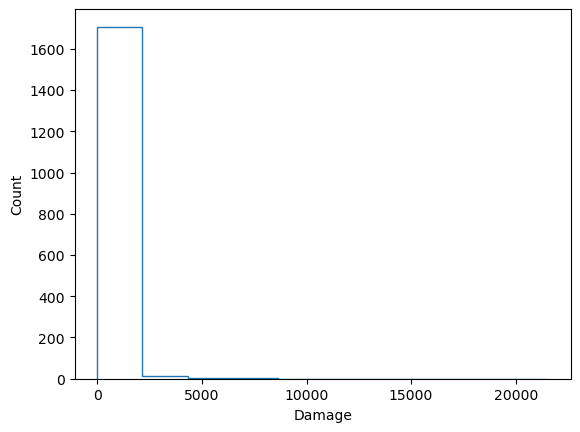

In [237]:
# Plot the dependent variable, 'Damage'

counts, bins = np.histogram(df['Damage'])
plt.stairs(counts, bins)
plt.xlabel('Damage')
plt.ylabel('Count')
plt.show()

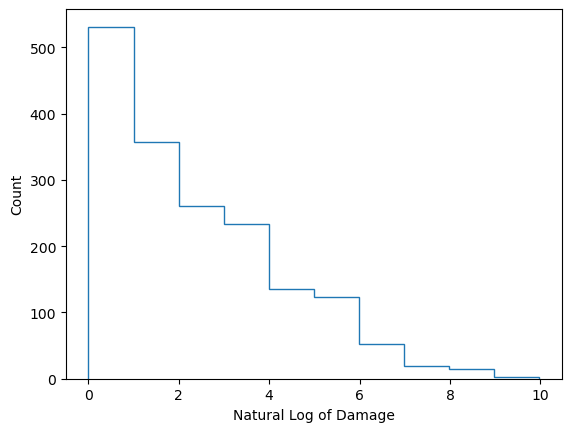

In [238]:
# Plot the dependent variable, 'Damage'

counts, bins = np.histogram(df['lnDamage'])
plt.stairs(counts, bins)
plt.xlabel('Natural Log of Damage')
plt.ylabel('Count')
plt.show()

Engineer a few additional features by combining some of the existing features.

In [239]:
# Factor distance from landfall into the maximum storm windspeed for counties further away from the strongest part of the storm
df['max_wind_speed_div_distance'] = df['Max Wind'] / df['dist_from_landfall']
df['wind_speed_closest_div_distance_closest'] = df['Closest_Max_Wind'] / df['distance_from_storm']
df['max_wind_x_pressure'] = df['Max Wind'] * df['Max Pressure']
df['max_wind_x_pressure_div_distance'] = df['Max Wind'] * df['Max Pressure']/ df['dist_from_landfall']
df['closest_wind_x_pressure_div_distance_'] = df['Closest_Max_Wind'] * df['Closest_Max_Pressure'] / df['distance_from_storm']


Identify the quantitative and categorical features.

In [240]:
categories = [
    'category',
    'housing_cluster',
    'econ_cluster'
]
print(categories)

quants = [x for x in df.columns.tolist() if x not in categories]
quants.remove('Damage')
quants.remove('lnDamage')
quants.remove('disasterNumber')

quants

['category', 'housing_cluster', 'econ_cluster']


['Estimate!!HOUSING OCCUPANCY!!Total housing units',
 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
 'Max Wind',
 'Max Pressure',
 'dist_from_landfall',
 'Closest_Max_Wind',
 'Closest_Max_Pressure',
 'dista

In [279]:
# Split the dataset into features and target subsets
X = df.drop(['Damage','lnDamage'], axis=1)
y = df['lnDamage'] # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)
y_ = df['Damage']

In [280]:
X.head()

,disasterNumber,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,...,Closest_Max_Pressure,distance_from_storm,category,housing_cluster,econ_cluster,max_wind_speed_div_distance,wind_speed_closest_div_distance_closest,max_wind_x_pressure,max_wind_x_pressure_div_distance,closest_wind_x_pressure_div_distance_
0,4798,14490.0,12610.0,607,2124,3029,2123,1930,1613,707,...,978,40.192025,TS,0,0.0,0.917686,1.741639,78240,897.497311,1703.322970
1,4798,39773.0,35163.0,450,5102,4043,7717,6694,6517,4276,...,1004,6.349638,TD,0,0.0,0.228661,3.937232,78240,223.630252,3952.981291
2,4798,151738.0,136014.0,5397,33277,30493,20487,19722,20481,11002,...,978,37.310013,TS,0,0.0,1.250476,1.876172,78240,1222.965060,1834.896164
3,4798,19330.0,17802.0,1588,4409,4838,2592,1614,1763,1033,...,988,79.163470,TS,0,0.0,0.717687,0.631604,78240,701.898105,624.025196
4,4798,314720.0,302947.0,16692,104372,74473,41857,37753,26000,6351,...,978,29.248125,TS,0,0.0,1.098007,2.393316,78240,1073.851311,2340.662865


In [243]:
preprocessor = ColumnTransformer(
    transformers=[
        ('quant', Normalizer(), quants),
        ('cat', OneHotEncoder(sparse_output=False,
                              handle_unknown='infrequent_if_exist',
                              ).set_output(transform='pandas'), categories)
    ]
).set_output(transform='pandas')
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                ])



In [281]:
lr_clf = LinearRegression(n_jobs = -1)
br_clf = BayesianRidge()
rf_clf = RandomForestRegressor(random_state=0,
                               n_jobs = -1)
SVR_clf = SVR(kernel='rbf')
gbr_clf = GradientBoostingRegressor(random_state=0)
hgbr_clf = HistGradientBoostingRegressor(random_state=0)
bgr_clf = BaggingRegressor(random_state=0,
                           n_jobs = -1)
mlpr_clf = MLPRegressor(max_iter=500,
                        random_state=0)
dummy_clf = DummyRegressor()
clf_list = [lr_clf,
            br_clf,
            rf_clf,
            SVR_clf,
            gbr_clf,
            hgbr_clf,
            bgr_clf,
            mlpr_clf,
            dummy_clf,
            ]

X_ = X.drop(['disasterNumber'], axis=1).copy()
X__ = pipe.fit_transform(X_)

scoring = {
    'r2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
}

for clf in clf_list:
    cross_val_results = cross_validate(clf, X__, y, cv=10, scoring=scoring)

    print(f'{clf} Mean R2: {cross_val_results['test_r2'].mean()}, {cross_val_results['test_r2'].std() }')
    print(f'{clf} Mean MAE: {-cross_val_results['test_MAE'].mean()}, {cross_val_results['test_MAE'].std() }')
    print(f'{clf} Mean RMSE: {-cross_val_results['test_RMSE'].mean()}, {cross_val_results['test_RMSE'].std() }')

    # print(f'{clf} Standard Deviation: {cross_val_results.std()}')


LinearRegression(n_jobs=-1) Mean R2: 0.23570272118495458, 0.15765275497240683
LinearRegression(n_jobs=-1) Mean MAE: 1.289319667934392, 0.17309947132237014
LinearRegression(n_jobs=-1) Mean RMSE: 1.6322432160139957, 0.28216240670862464
BayesianRidge() Mean R2: 0.1411798531490233, 0.1923015748174749
BayesianRidge() Mean MAE: 1.3988334934331772, 0.23651843037303918
BayesianRidge() Mean RMSE: 1.7366622589951697, 0.34272658555992286
RandomForestRegressor(n_jobs=-1, random_state=0) Mean R2: 0.2412937523458623, 0.20599216277976737
RandomForestRegressor(n_jobs=-1, random_state=0) Mean MAE: 1.2817833282275708, 0.20825022038320679
RandomForestRegressor(n_jobs=-1, random_state=0) Mean RMSE: 1.6197043255759536, 0.3092752777269845
SVR() Mean R2: 0.0007302210455510272, 0.23167634925807945
SVR() Mean MAE: 1.4891966540301003, 0.28640697878426596
SVR() Mean RMSE: 1.8719772554902303, 0.36009707679818354
GradientBoostingRegressor(random_state=0) Mean R2: 0.2057941487689004, 0.20766992931647657
GradientBoo

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/josch

MLPRegressor(max_iter=500, random_state=0) Mean R2: 0.24700265717773298, 0.22352713096748666
MLPRegressor(max_iter=500, random_state=0) Mean MAE: 1.2816908927095902, 0.21669902021287574
MLPRegressor(max_iter=500, random_state=0) Mean RMSE: 1.6087621927101778, 0.32934542341697015
DummyRegressor() Mean R2: -0.15969265545946437, 0.23169333775307568
DummyRegressor() Mean MAE: 1.6651438254122286, 0.21950067870287418
DummyRegressor() Mean RMSE: 2.010969826717165, 0.2685696086927934


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



The results are very disappointing. This could be caused in part to the high number of low/no damage entries, which is primarily tied to storm strength. This is measured by the feature 'category'.

Stratifying on storm category as we want to have an better spread of damages in each fold for better training results.

In [245]:
groups = X['category'].astype(str)
skfold = StratifiedKFold(n_splits=10,
                         shuffle=True,
                         random_state=0)

for clf in clf_list:
    cross_val_results = cross_validate(clf,
                                        X__,
                                        y,
                                        cv=skfold.split(X__, groups),
                                        scoring=scoring,
                                        )

    print(f'{clf} Mean R2: {cross_val_results['test_r2'].mean()}, {cross_val_results['test_r2'].std() }')
    print(f'{clf} Mean MAE: {-cross_val_results['test_MAE'].mean()}, {cross_val_results['test_MAE'].std() }')
    print(f'{clf} Mean RMSE: {-cross_val_results['test_RMSE'].mean()} ,{cross_val_results['test_RMSE'].std() }')
    # print(f'{clf} Mean: {cross_val_results.mean()}')
    # print(f'{clf} Standard Deviation: {cross_val_results.std()}')


LinearRegression(n_jobs=-1) Mean R2: 0.42043642542442783, 0.060131676040062934
LinearRegression(n_jobs=-1) Mean MAE: 1.1872461839609403, 0.04685411133889636
LinearRegression(n_jobs=-1) Mean RMSE: 1.5192227861777508 ,0.05235728096295602
BayesianRidge() Mean R2: 0.3694048268731052, 0.062426092464194304
BayesianRidge() Mean MAE: 1.2546577511000208, 0.04169090034582835
BayesianRidge() Mean RMSE: 1.5852951254689311 ,0.06336775195633476
RandomForestRegressor(n_jobs=-1, random_state=0) Mean R2: 0.5057517720068778, 0.07750493227150644
RandomForestRegressor(n_jobs=-1, random_state=0) Mean MAE: 1.0721993759354855, 0.06302747702715675
RandomForestRegressor(n_jobs=-1, random_state=0) Mean RMSE: 1.3995407389276604 ,0.07599455057930804
SVR() Mean R2: 0.27176135716485006, 0.05299876864949733
SVR() Mean MAE: 1.3187624418098245, 0.053096671340924606
SVR() Mean RMSE: 1.7051765885950652 ,0.06054154219764789
GradientBoostingRegressor(random_state=0) Mean R2: 0.46008765516763733, 0.08593224735585635
Gradie

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/josch

MLPRegressor(max_iter=500, random_state=0) Mean R2: 0.4273268453038465, 0.07595132554394911
MLPRegressor(max_iter=500, random_state=0) Mean MAE: 1.1834521222251189, 0.05080870598725747
MLPRegressor(max_iter=500, random_state=0) Mean RMSE: 1.5090957970223169 ,0.07748970979017104
DummyRegressor() Mean R2: -0.003006484907367435, 0.004259182816252599
DummyRegressor() Mean MAE: 1.6478855915461086, 0.08135552357700768
DummyRegressor() Mean RMSE: 2.005546333397478 ,0.1094754102847615


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



In [246]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=50,
                                                      stratify=groups)

pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_score = mean_absolute_error(y_test, lr_preds)

br_clf.fit(X_train, y_train)
br_preds = br_clf.predict(X_test)
br_score = mean_absolute_error(y_test, br_preds)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
rf_score = mean_absolute_error(y_test, rf_preds)

SVR_clf.fit(X_train, y_train)
SVR_preds = SVR_clf.predict(X_test)
SVR_score = mean_absolute_error(y_test, SVR_preds)

gbr_clf.fit(X_train, y_train)
gbr_preds = gbr_clf.predict(X_test)
gbr_score = mean_absolute_error(y_test, gbr_preds)

hgbr_clf.fit(X_train, y_train)
hgbr_preds = hgbr_clf.predict(X_test)
hgbr_score = mean_absolute_error(y_test, hgbr_preds)

bgr_clf.fit(X_train, y_train)
bgr_preds = bgr_clf.predict(X_test)
bgr_score = mean_absolute_error(y_test, bgr_preds)

mlpr_clf.fit(X_train, y_train)
mlpr_preds = mlpr_clf.predict(X_test)
mlpr_score = mean_absolute_error(y_test, mlpr_preds)

dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_test)
dummy_score = mean_absolute_error(y_test, dummy_preds)

print(f'Linear Regression MAE Score: {lr_score}')
print(f'Bayesian Ridge MAE Score: {br_score}')
print(f'Random Forest MAE Score: {rf_score}')
print(f'SVR MAE Score: {SVR_score}')
print(f'Gradient Boosting Regressor MAE Score: {gbr_score}')
print(f'Hist Gradient Boosting Regressor MAE Score: {hgbr_score}')
print(f'Bagging Regressor MAE Score: {bgr_score}')
print(f'MLP Regressor MAE Score: {mlpr_score}')
print(f'Dummy Regressor MAE Score: {dummy_score}')


Linear Regression MAE Score: 1.142163917422853
Bayesian Ridge MAE Score: 1.2303822838125962
Random Forest MAE Score: 1.0350143979312207
SVR MAE Score: 1.2778481022873143
Gradient Boosting Regressor MAE Score: 1.1174113902788507
Hist Gradient Boosting Regressor MAE Score: 1.050635193420126
Bagging Regressor MAE Score: 1.0905123990074779
MLP Regressor MAE Score: 1.16888865046179
Dummy Regressor MAE Score: 1.534581739010279


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



In [247]:
# Model metrics for random forest model
print(f'Score: {rf_clf.score(X_test, y_test)}')
print(f'R2 Score: {r2_score(y_test, rf_preds)}')
print(f'MSE: {mean_squared_error(y_test, rf_preds)}')
print(f'MAE: {mean_absolute_error(y_test, rf_preds)}')
print(f'Median Absolute Error: {median_absolute_error(y_test, rf_preds)}')
print(f'RMSE: {root_mean_squared_error(y_test, rf_preds)}')
print(f'Cross Validation Score: {cross_val_score(rf_clf, X_train, y_train, cv=5).mean()}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, rf_preds)}')

Score: 0.49484946854770084
R2 Score: 0.49484946854770084
MSE: 1.7592847317001994
MAE: 1.0350143979312207
Median Absolute Error: 0.7993042630604128
RMSE: 1.3263803118639086
Cross Validation Score: 0.4846335358937181
MAPE: 1008075871927984.9


Why is our MAPE value so high?

In [248]:
y.describe()

count    1730.000000
mean        2.312448
std         2.008557
min         0.000000
25%         0.693147
50%         1.945910
75%         3.583519
max         9.978409
Name: lnDamage, dtype: float64

Our target has many values at or near zero, so MAPE is not a good choice in this situation.

In [249]:
param_dist = {
    "max_depth": stats.randint(5, 30),
    "n_estimators": stats.randint(50, 200),
    "max_features": stats.uniform(.5, 1),
    "max_samples": stats.uniform(.2, .99),

}

clf = RandomForestRegressor(random_state=0,
                            n_jobs = -1)
groups_train = X_train_['category']

n_iter_search = 60
random_search_rfr = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    random_state=0,
    cv = skfold.split(X_train, groups_train),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

random_search_rfr.fit(X_train, y_train)

print(random_search_rfr.best_params_)
best_model_rfr = random_search_rfr.best_estimator_
best_model_rfr.fit(X_train, y_train)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


410 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/U

{'max_depth': 29, 'max_features': np.float64(0.5503700567575438), 'max_samples': np.float64(0.892107093971326), 'n_estimators': 75}


RandomForestRegressor(max_depth=29, max_features=np.float64(0.5503700567575438),
                      max_samples=np.float64(0.892107093971326),
                      n_estimators=75, n_jobs=-1, random_state=0)

In [250]:
max_features = random_search_rfr.best_params_['max_features']
num_estimators = random_search_rfr.best_params_['n_estimators']

In [ ]:
training_scores = random_search_rfr.cv_results_
mean_mae = -np.nanmean(training_scores['mean_test_score'])
std_mae = np.nanstd(training_scores['mean_test_score'])
print(f'Mean MAE Score: {mean_mae, std_mae}')
# training_scores['mean_test_score']

Mean MAE Score: (np.float64(-1.1284723759455542), np.float64(0.031040349849993733))


In [252]:
rfr_preds = best_model_rfr.predict(X_test)
rfr_score = best_model_rfr.score(X_test, y_test)
print(f'RandomSearchCV Best Model Random Forest Regressor R2 Score: {rfr_score}')

rfr_preds = rf_clf.predict(X_test)
rfr_score = rf_clf.score(X_test, y_test)
print(f'Random Forest Regressor R2 Score: {rfr_score}')

RandomSearchCV Best Model Random Forest Regressor R2 Score: 0.480885879604001
Random Forest Regressor R2 Score: 0.49484946854770084


In [253]:
states = list(range(1,11))
score_list_rf = []
score_list_best_fit = []
for i in states:
    X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=i,
                                                        stratify=groups)

    pipe.fit(X_train_)
    X_train = pipe.transform(X_train_)
    X_test = pipe.transform(X_test_)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    score_list_rf.append(mean_absolute_error(y_test, y_pred))
    
    best_model_rfr.fit(X_train, y_train)
    y_pred = best_model_rfr.predict(X_test)
    score_list_best_fit.append(mean_absolute_error(y_test, y_pred))

print('Results for plain RFR')
print(score_list_rf)
print(np.mean(score_list_rf))
print(np.std(score_list_rf))

print('Results for best fit RFR')
print(score_list_best_fit)
print(np.mean(score_list_best_fit))
print(np.std(score_list_best_fit))

Results for plain RFR
[1.0916653051608145, 1.044991161752889, 1.0486388041456467, 1.0587401527265998, 1.0846976618142254, 1.1137811548798517, 1.0186173833364403, 1.08408483867674, 1.1208842794787188, 1.108123537725084]
1.0774224279697013
0.03184488766722691
Results for best fit RFR
[1.1094005500480082, 1.0741821358062342, 1.0732399675507645, 1.0671634005663433, 1.105805624990946, 1.117819318638141, 1.0132861426248794, 1.097660116107743, 1.1419430852432249, 1.1084982354123258]
1.0908998576988609
0.033806200723214164


Hyperparameter sensitivity analysis

Max depth, max features, and number of estimators are the most likely to impact performance the most.

In [254]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=50,
                                                    stratify=groups)
groups_train = X_train_['category']
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

depths = list(range(1,31,1))
results = []
for depth in depths:
    clf = RandomForestRegressor(max_depth=depth, 
                                max_features=max_features,
                                n_estimators=num_estimators,
                                random_state=0,
                                n_jobs = -1,
                                )
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((depth, mean_mae, std_mae))

df_results = pd.DataFrame(results, columns=['model_depth', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

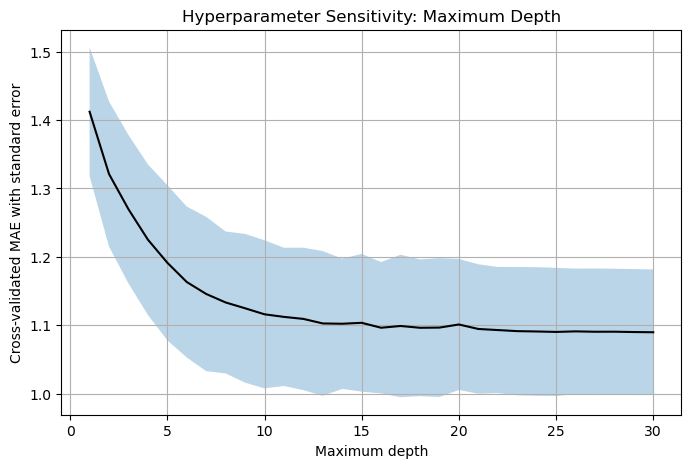

In [255]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results['model_depth'],
         df_results['mean_mae'],
         color='k')
plt.fill_between(df_results['model_depth'], 
                 df_results['mean_mae']-df_results['std_mae'].abs(),
                 df_results['mean_mae']+df_results['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Maximum depth')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Maximum Depth')
plt.grid(True)
plt.show()

In [256]:
df_results[df_results['model_depth']>=15]

,model_depth,mean_mae,std_mae
14,15,1.103498,0.100721
15,16,1.096269,0.096082
16,17,1.098854,0.104191
17,18,1.096212,0.099985
18,19,1.096488,0.101594
19,20,1.101052,0.095843
20,21,1.094472,0.094657
21,22,1.092901,0.092275
22,23,1.091306,0.093794
23,24,1.090814,0.094091


In [257]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=50,
                                                    stratify=groups)
groups_train = X_train_['category']
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

estimators = list(range(10,200,5))
results = []
for estimator in estimators:
    clf = RandomForestRegressor(max_depth = 15, 
                                max_features = max_features,
                                n_estimators = estimator, 
                                random_state = 0,
                                n_jobs = -1)
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs=-1
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((estimator, mean_mae, std_mae))

df_results2 = pd.DataFrame(results, columns=['n_estimators', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

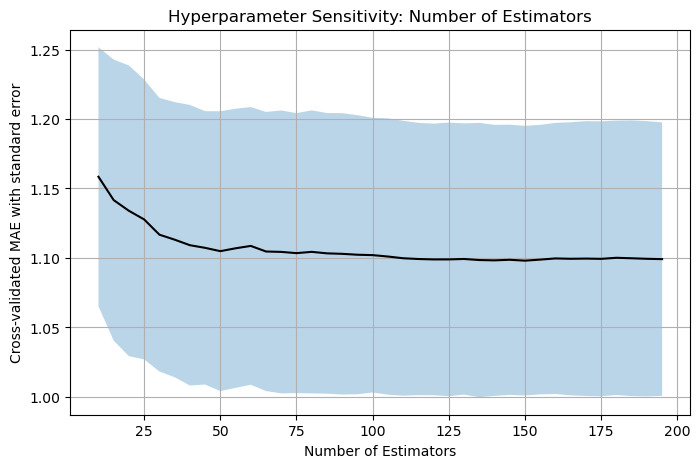

In [258]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results2['n_estimators'],
         df_results2['mean_mae'],
         color='k')
plt.fill_between(df_results2['n_estimators'], 
                 df_results2['mean_mae']-df_results2['std_mae'].abs(),
                 df_results2['mean_mae']+df_results2['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Number of Estimators')
plt.grid(True)
plt.show()

In [259]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=50,
                                                    stratify=groups)
groups_train = X_train_['category']
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

features = list(range(1,X_train.shape[1]+1,1))
results = []
for feature in features:
    clf = RandomForestRegressor(max_depth=15, 
                                max_features=feature,
                                n_estimators=50,
                                random_state=0,
                                n_jobs = -1,
                                )
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((feature, mean_mae, std_mae))

df_results3 = pd.DataFrame(results, columns=['model_features', 'mean_mae', 'std_mae'])


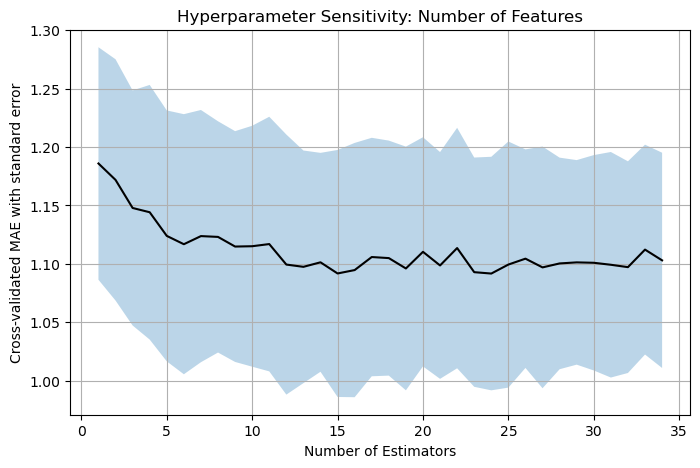

In [260]:
plt.figure(figsize=(8, 5))
plt.plot(df_results3['model_features'],
         df_results3['mean_mae'],
         color='k')
plt.fill_between(df_results3['model_features'], 
                 df_results3['mean_mae']-df_results3['std_mae'].abs(),
                 df_results3['mean_mae']+df_results3['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Number of Features')
plt.grid(True)
plt.show()

In [261]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=50,
                                                    stratify=groups)
groups_train = X_train_['category']
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

features = list(range(1,21,1))
depths = list(range(1,31,1))

results = []
for feature in features:
    for depth in depths:
        clf = RandomForestRegressor(max_depth=depth, 
                                    max_features=feature,
                                    n_estimators=50,
                                    random_state=0,
                                    n_jobs = -1,
                                    )
        scores = cross_val_score(clf,
                                X_train,
                                y_train,
                                cv = skfold.split(X_train, groups_train),
                                scoring = 'neg_mean_absolute_error',
                                n_jobs = -1,
                                )
        mean_mae = -np.mean(scores)
        std_mae = np.std(scores)
        results.append((feature, depth, mean_mae, std_mae))

df_results4 = pd.DataFrame(results, 
                           columns=['model_features', 'model_depth', 'mean_mae', 'std_mae'])


In [262]:
# Save the results for later use as the analysis takes an hour to run
df_results4.to_csv('df_results4.csv')

In [ ]:
Z_grid = df_results4.pivot_table(index='model_depth',
                                 columns='model_features',
                                 values='mean_mae',
                                 ).sort_index(ascending=True)
x = Z_grid.columns.values
y = Z_grid.index.values
z = Z_grid.values

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title=dict(text='Hyperparameter Sensitivity Analysis'), 
                #   autosize=True, 
                  width=600, 
                  height=400,
                  margin=dict(l=20, r=20, b=50, t=50),
                  scene=dict(
                      xaxis_title = 'Features',
                      yaxis_title = 'Depth',
                      zaxis_title = 'Mean MAE'
                  )
                  )
fig.show()

In [283]:
df_results4.sort_values(by='mean_mae', ascending=True).head()

,model_features,model_depth,mean_mae,std_mae
533,18,24,1.088143,0.100720
539,18,30,1.088361,0.098294
535,18,26,1.088686,0.098332
538,18,29,1.088705,0.098766
534,18,25,1.089097,0.099365


In [284]:
new_best_model_rfr = RandomForestRegressor(max_depth=24, 
                                    max_features=18,
                                    n_estimators=135,
                                    random_state=0,
                                    n_jobs = -1,
                                    )
new_best_model_rfr.fit(X_train, y_train)
new_y_pred = new_best_model_rfr.predict(X_test)
print(r2_score(y_test, new_y_pred))
print(mean_absolute_error(y_test, new_y_pred))

0.49799157531079374
1.0839800696091746


/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_1597/120606719.py:9: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



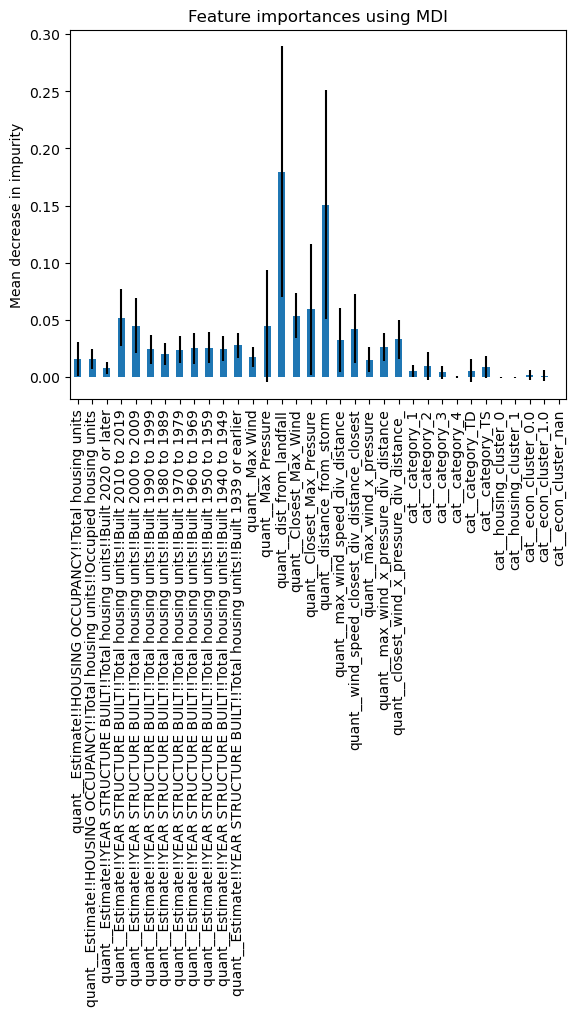

In [285]:
importances = new_best_model_rfr.feature_importances_
feature_names = [i for i in X__.columns]
std = np.std([tree.feature_importances_ for tree in new_best_model_rfr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

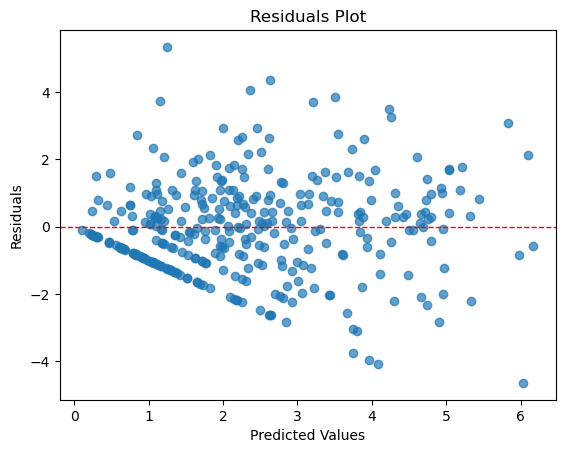

In [286]:
y_pred = new_best_model_rfr.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

Feature Importance Ranking:
 Index(['quant__dist_from_landfall', 'quant__distance_from_storm',
       'quant__Closest_Max_Pressure', 'quant__Closest_Max_Wind',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'quant__Max Pressure', 'quant__wind_speed_closest_div_distance_closest',
       'quant__closest_wind_x_pressure_div_distance_',
       'quant__max_wind_speed_div_distance',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
       'quant__max_wind_x_pressure_div_distance',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_1597/1642923347.py:19: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_1597/1642923347.py:25: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



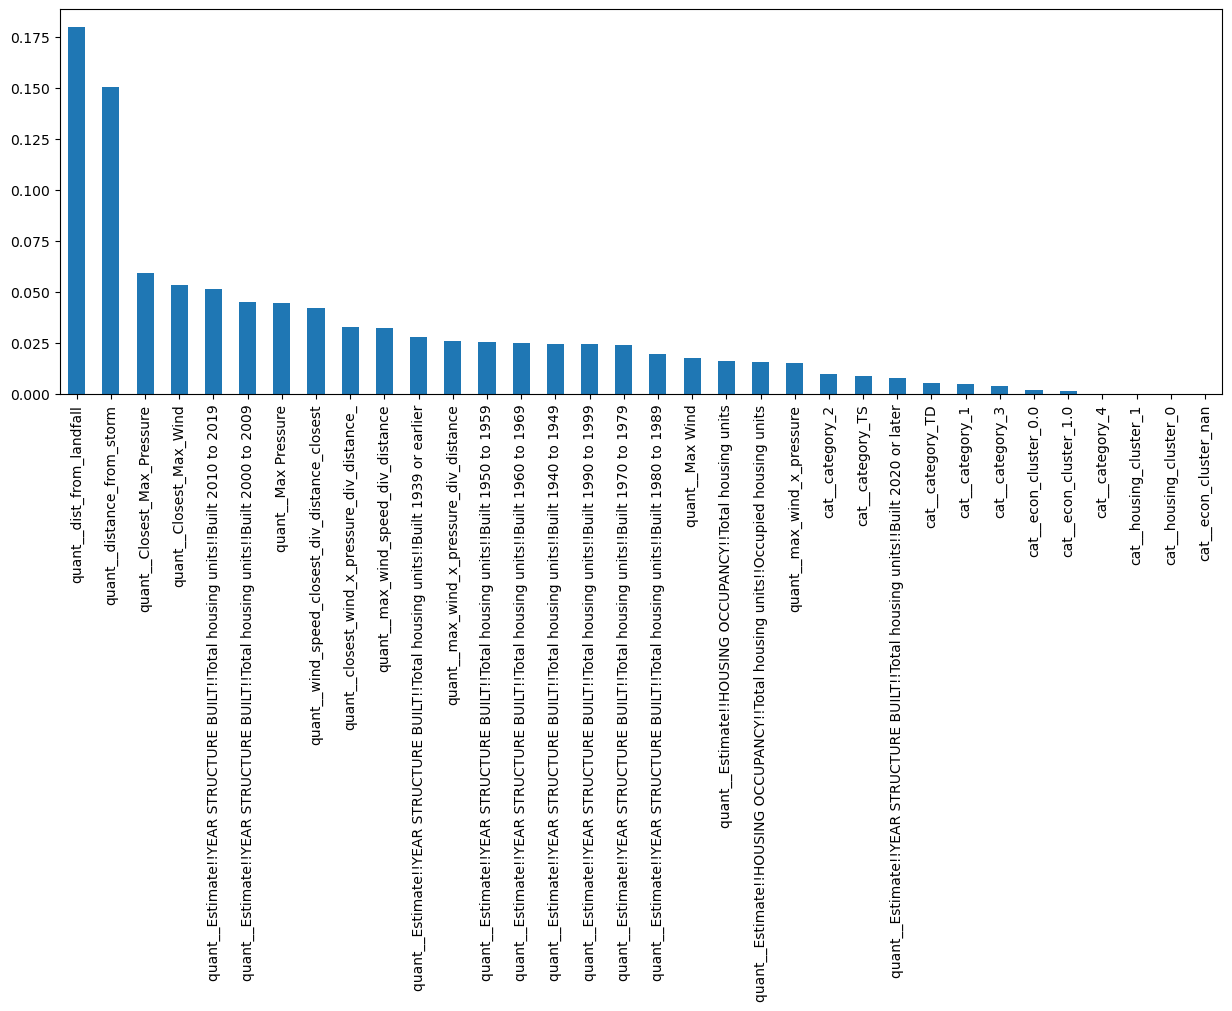

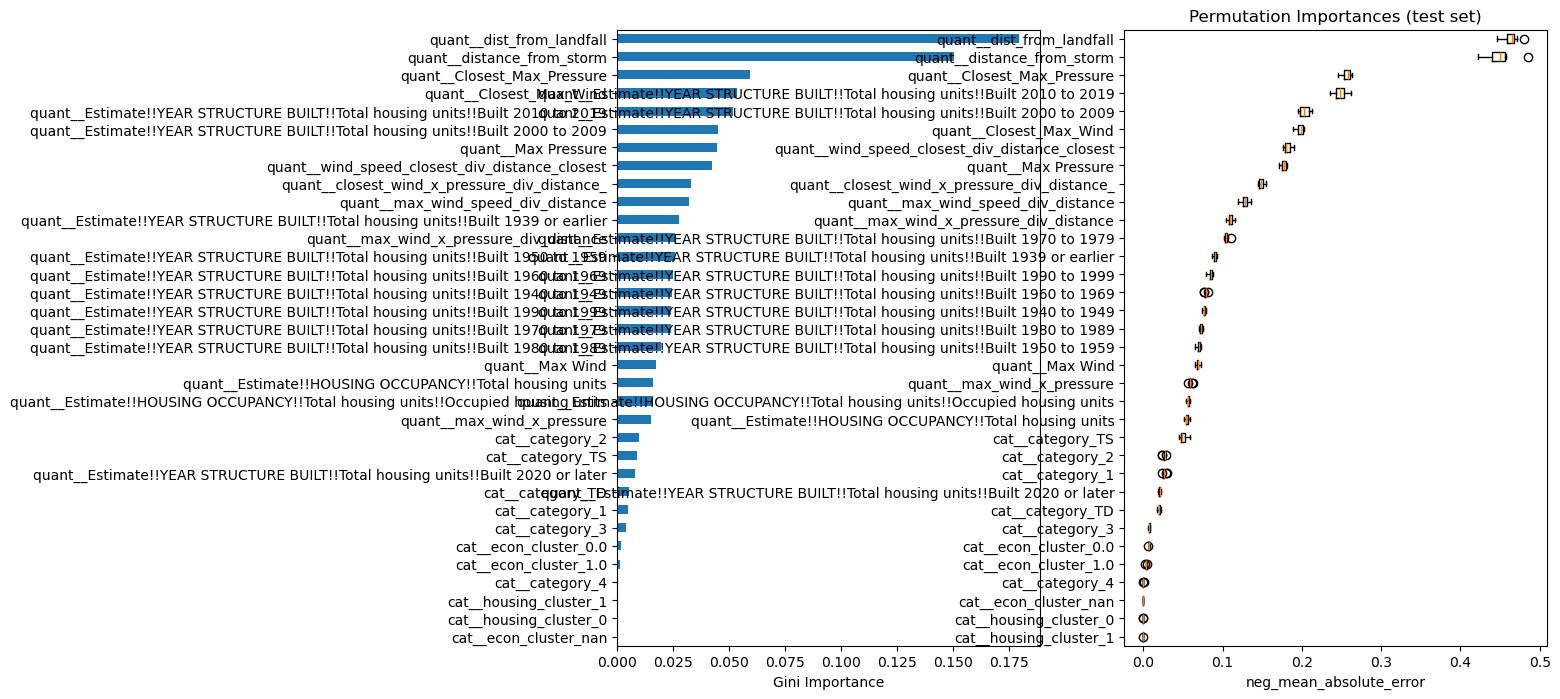

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_1597/1642923347.py:59: UserWarning:

Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_1597/1642923347.py:19: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_1597/1642923347.py:25: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



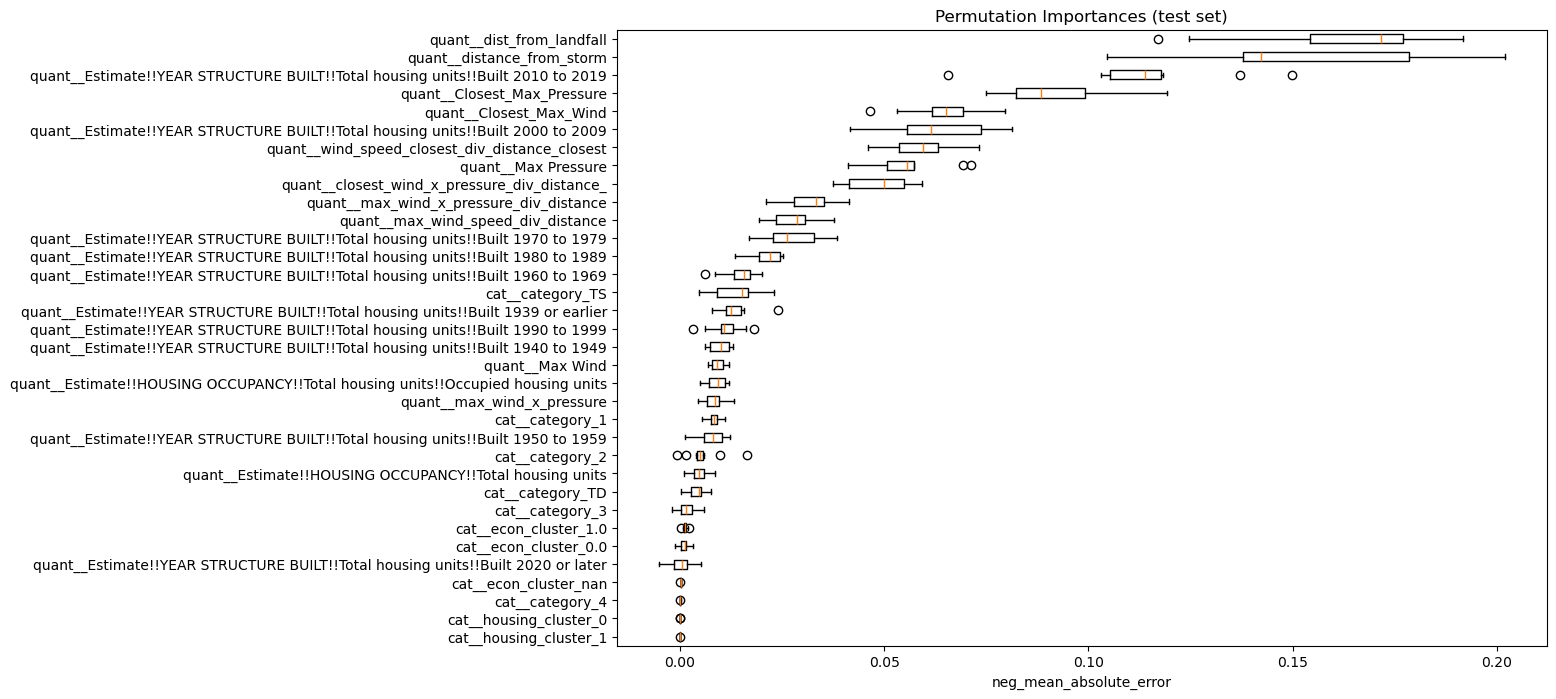

In [287]:
display_feature_importance(new_best_model_rfr,
                           X_train,
                           X_test,
                           y_train,
                           y_test)

In [289]:
states = list(range(1,11))
learning_curves = []
ratios = [.3, .4, .5, .6, .7, .8, .9]
                    

for j in ratios:
    states = list(range(1,11))
    score_list = []
    for i in states:
        X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                              y,
                                                              train_size=j,
                                                              random_state=i,
                                                              stratify=groups,
                                                              )
        pipe.fit(X_train_)
        X_train = pipe.transform(X_train_)
        X_test = pipe.transform(X_test_)
        new_best_model_rfr.fit(X_train, y_train)
        rf_preds = new_best_model_rfr.predict(X_test)
        rf_score = mean_absolute_error(y_test, rf_preds)
        score_list.append(rf_score)
        learning_curves.append((j, i, rf_score))
    print(f'Train size: {j}')    
    print(f'Mean MAE: {np.mean(score_list)}')
    print(f'STD MAE: {np.std(score_list)}')

states = list(range(1,11))
score_list = []
for i in states:
    X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=i,
                                                          stratify=groups,
                                                          )
    pipe.fit(X_train_)
    X_train = pipe.transform(X_train_)
    X_test = pipe.transform(X_test_)
    new_best_model_rfr.fit(X_train, y_train)
    rf_preds = new_best_model_rfr.predict(X_test)
    rf_score = mean_absolute_error(y_test, rf_preds)
    score_list.append(rf_score)
print(f'Random state test')
print(f'Mean MAE: {np.mean(score_list)}')
print(f'STD MAE: {np.std(score_list)}')

Train size: 0.3
Mean MAE: 1.1660401613548026
STD MAE: 0.012274524006195626
Train size: 0.4
Mean MAE: 1.1391196137125
STD MAE: 0.007100407364679206
Train size: 0.5
Mean MAE: 1.122349497803985
STD MAE: 0.014107912287009526
Train size: 0.6
Mean MAE: 1.1083900931779314
STD MAE: 0.02005440305695258
Train size: 0.7
Mean MAE: 1.082541238344286
STD MAE: 0.030454887905713712
Train size: 0.8
Mean MAE: 1.078882798670926
STD MAE: 0.03679561806471099
Train size: 0.9
Mean MAE: 1.0497939629296258
STD MAE: 0.06874235927837764
Random state test
Mean MAE: 1.078882798670926
STD MAE: 0.03679561806471099


In [ ]:
df_learning = pd.DataFrame(learning_curves,
    columns=['train_size', 'random_state', 'MAE'],
    )
df_learning.tail()

,train_size,random_state,MAE
0,0.3,1,1.180213
1,0.3,2,1.170911
2,0.3,3,1.189694
3,0.3,4,1.149643
4,0.3,5,1.155428
...,...,...,...
65,0.9,6,1.095560
66,0.9,7,0.977852
67,0.9,8,1.064887
68,0.9,9,1.118204


In [291]:
df_learning_curves = df_learning.groupby('train_size').agg(
    mean_mae = ('MAE', 'mean'),
    std_mae = ('MAE', 'std')
).reset_index()

df_learning_curves

,train_size,mean_mae,std_mae
0,0.3,1.166040,0.012938
1,0.4,1.139120,0.007484
2,0.5,1.122349,0.014871
3,0.6,1.108390,0.021139
4,0.7,1.082541,0.032102
5,0.8,1.078883,0.038786
6,0.9,1.049794,0.072461


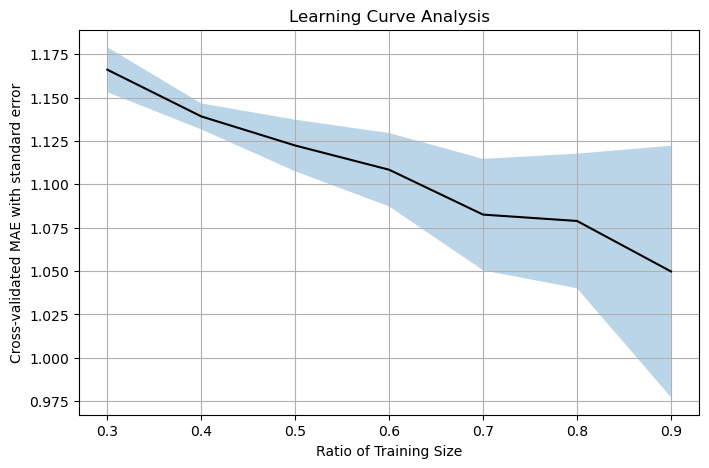

In [292]:
plt.figure(figsize=(8, 5))
plt.plot(df_learning_curves['train_size'],
         df_learning_curves['mean_mae'],
         color='k')
plt.fill_between(df_learning_curves['train_size'], 
                 df_learning_curves['mean_mae']-df_learning_curves['std_mae'].abs(),
                 df_learning_curves['mean_mae']+df_learning_curves['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Ratio of Training Size')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Learning Curve Analysis')
plt.grid(True)
plt.show()

In [293]:
drop_list = [
    [
        'Estimate!!HOUSING OCCUPANCY!!Total housing units',
        'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
    ],
    [
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    ],
    [
        'Max Wind',
        'Max Pressure',
        'dist_from_landfall',
    ],
    [
        'category'
    ],
]
for item_list in drop_list:
    _ = X_.drop(labels=item_list,
        axis=1,
        )

    _quants = quants.copy()
    _categories = categories.copy()
    for item in item_list:
        try:
            _quants.remove(item)
        except:
            _categories.remove(item)

    preprocessor = ColumnTransformer(
        transformers=[
            ('quant', Normalizer(), _quants),
            ('cat', OneHotEncoder(sparse_output=False,
                                  handle_unknown='infrequent_if_exist',
                                  ).set_output(transform='pandas'), _categories)
        ]
    ).set_output(transform='pandas')
    pipe1 = Pipeline(steps=
                    [('preprocessor', preprocessor),
                    ])
    states = list(range(1,11))
    score_list = []
    for i in states:
        X_train_, X_test_, y_train, y_test = train_test_split(_,
                                                              y,
                                                              test_size=0.2,
                                                              random_state=i,
                                                              stratify=groups)
        pipe1.fit(X_train_)
        X_train = pipe1.transform(X_train_)
        X_test = pipe1.transform(X_test_)
        new_best_model_rfr.fit(X_train, y_train)
        rf_preds = new_best_model_rfr.predict(X_test)
        rf_score = mean_absolute_error(y_test, rf_preds)
        score_list.append(rf_score)
    print(item_list)
    print(score_list)
    print(np.mean(score_list))
    print(np.std(score_list))



['Estimate!!HOUSING OCCUPANCY!!Total housing units', 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units']
[1.0660533795655431, 1.0258004485277532, 1.0262671966734878, 1.015748175464753, 1.0212385821100995, 1.0770190466875689, 0.9685751592478218, 1.0482592196080327, 1.095804451464582, 1.0336011349936687]
1.037836679434331
0.03414315839392952
['Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959', 'Estimate!!YEAR STRUCTURE BUILT!

In [294]:
new_best_model_rfr.fit(X_train, y_train)

df_compare = X_test.copy()
df_compare['target'] = y_test
df_compare['prediction'] = new_best_model_rfr.predict(X_test)
df_compare['delta'] = df_compare['prediction'] - df_compare['target']
df_compare = df_compare.assign(entry=range(1, len(df_compare)+1))
df_compare

,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,...,quant__closest_wind_x_pressure_div_distance_,cat__housing_cluster_0,cat__housing_cluster_1,cat__econ_cluster_0.0,cat__econ_cluster_1.0,cat__econ_cluster_nan,target,prediction,delta,entry
1320,0.130215,0.108432,0.000000,0.000000,0.028027,0.034257,0.017649,0.014997,0.017179,0.011234,...,0.060350,1.0,0.0,1.0,0.0,0.0,8.218248,5.943576,-2.274672,1
1465,0.266229,0.235025,0.000000,0.000000,0.038934,0.040385,0.037213,0.038664,0.033976,0.028703,...,0.018474,1.0,0.0,1.0,0.0,0.0,2.564949,2.496658,-0.068292,2
1056,0.211305,0.180202,0.000000,0.007317,0.037450,0.039531,0.047610,0.044288,0.020166,0.010729,...,0.022544,1.0,0.0,0.0,1.0,0.0,1.098612,0.818634,-0.279978,3
478,0.051249,0.040889,0.000000,0.000000,0.002310,0.008170,0.011410,0.010180,0.007380,0.004250,...,0.011894,1.0,0.0,1.0,0.0,0.0,1.098612,0.898936,-0.199676,4
423,0.473646,0.384175,0.004102,0.026420,0.067793,0.088055,0.138800,0.085153,0.025556,0.022462,...,0.012189,1.0,0.0,1.0,0.0,0.0,2.772589,3.570941,0.798352,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,0.628620,0.554073,0.014704,0.097995,0.101780,0.067635,0.079155,0.075717,0.045170,0.059140,...,0.002001,1.0,0.0,1.0,0.0,0.0,2.890372,2.476098,-0.414273,342
161,0.209207,0.186640,0.000000,0.000000,0.020192,0.039017,0.038843,0.038721,0.030369,0.019498,...,0.037656,1.0,0.0,1.0,0.0,0.0,5.337538,3.943906,-1.393632,343
113,0.054983,0.038983,0.000000,0.000000,0.004133,0.009458,0.010939,0.013359,0.008840,0.003801,...,0.014653,1.0,0.0,1.0,0.0,0.0,0.000000,1.368375,1.368375,344
1108,0.124074,0.100318,0.000000,0.000246,0.024462,0.031044,0.021372,0.019732,0.011534,0.011248,...,0.055959,1.0,0.0,0.0,1.0,0.0,5.075174,4.777860,-0.297314,345


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6a6374cd-5e77-49b2-b1d3-d73b9b2f23ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

(51, 32)


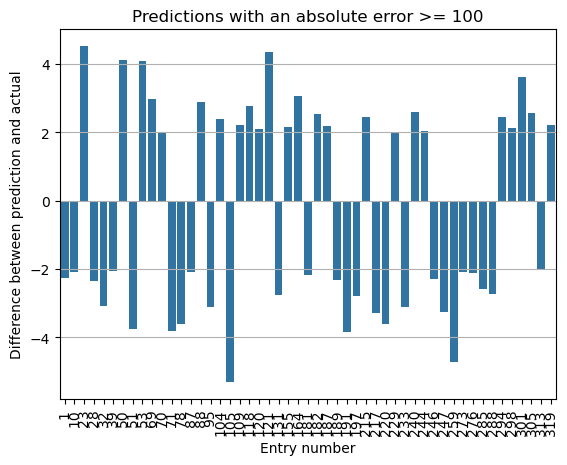

In [295]:
print(df_compare[df_compare['delta'].abs()>2].shape)
sns.barplot(data = df_compare[df_compare['delta'].abs()>2],
            x = 'entry',
            y='delta'
            )
plt.title('Predictions with an absolute error >= 100')
plt.ylabel('Difference between prediction and actual')
plt.xlabel('Entry number')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

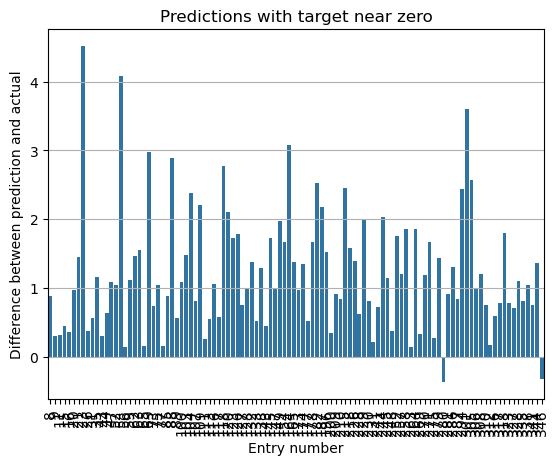

In [296]:
sns.barplot(data = df_compare[df_compare['target']<1.01],
            x = 'entry',
            y='delta'
            )
plt.title('Predictions with target near zero')
plt.ylabel('Difference between prediction and actual')
plt.xlabel('Entry number')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

In [297]:
df_largest_deltas = df_compare[df_compare['delta'].abs()>4]
df_largest_deltas

,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,...,quant__closest_wind_x_pressure_div_distance_,cat__housing_cluster_0,cat__housing_cluster_1,cat__econ_cluster_0.0,cat__econ_cluster_1.0,cat__econ_cluster_nan,target,prediction,delta,entry
986,0.184489,0.153437,0.000000,0.006897,0.058431,0.048604,0.029987,0.020033,0.008173,0.006070,...,0.063387,1.0,0.0,1.0,0.0,0.0,0.000000,4.512029,4.512029,23
1173,0.713999,0.572933,0.000000,0.000569,0.031178,0.052597,0.064334,0.136955,0.173503,0.157962,...,0.007085,1.0,0.0,0.0,1.0,0.0,2.079442,6.177420,4.097978,50
204,0.699892,0.611031,0.016901,0.113410,0.164752,0.132506,0.104980,0.074340,0.038407,0.031959,...,0.004130,1.0,0.0,1.0,0.0,0.0,0.000000,4.083566,4.083566,53
97,0.042122,0.029346,0.000000,0.000000,0.014933,0.008329,0.006393,0.003772,0.002588,0.002787,...,0.009944,1.0,0.0,1.0,0.0,0.0,6.594413,1.284129,-5.310284,105
958,0.703636,0.651289,0.017384,0.113624,0.129828,0.098790,0.128615,0.090156,0.050559,0.041933,...,0.000937,1.0,0.0,1.0,0.0,0.0,1.386294,5.720477,4.334183,121
794,0.614441,0.474228,0.020660,0.064536,0.135016,0.093291,0.146772,0.100337,0.035801,0.014424,...,0.003217,1.0,0.0,1.0,0.0,0.0,6.431331,1.701973,-4.729358,259


In [298]:
X_train.to_csv('xtrain.csv')
X_test.to_csv('xtest.csv')
y_train.to_csv('ytrain.csv')
y_test.to_csv('ytest.csv')
